In [25]:
import pandas as pd
df = pd.read_csv("EURUSD_Candlestick_1_Hour_BID_01.07.2020-15.07.2023.csv")
df=df[df['Volume']!=0]
df.reset_index(drop=True, inplace=True)
df.head(10)

,Gmt time,Open,High,Low,Close,Volume
0,01.07.2020 00:00:00.000,1.12336,1.12336,1.12275,1.12306,4148.0298
1,01.07.2020 01:00:00.000,1.12306,1.12395,1.12288,1.12385,5375.5801
2,01.07.2020 02:00:00.000,1.12386,1.12406,1.12363,1.12382,4131.6099
3,01.07.2020 03:00:00.000,1.12382,1.12388,1.12221,1.12265,4440.6001
4,01.07.2020 04:00:00.000,1.12265,1.12272,1.12151,1.12179,4833.1001
5,01.07.2020 05:00:00.000,1.12179,1.12261,1.12156,1.12240,6689.5601
6,01.07.2020 06:00:00.000,1.12240,1.12343,1.12202,1.12333,7562.7500
7,01.07.2020 07:00:00.000,1.12331,1.12331,1.12231,1.12315,8641.7500
8,01.07.2020 08:00:00.000,1.12315,1.12448,1.12290,1.12311,10042.7695
9,01.07.2020 09:00:00.000,1.12313,1.12337,1.12076,1.12076,9587.4004


In [27]:
df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')

In [28]:
def detect_fvg(data, lookback_period=10, body_multiplier=1.5):
    """
    Detects Fair Value Gaps (FVGs) in historical price data.

    Parameters:
        data (DataFrame): DataFrame with columns ['open', 'high', 'low', 'close'].
        lookback_period (int): Number of candles to look back for average body size.
        body_multiplier (float): Multiplier to determine significant body size.

    Returns:
        list of tuples: Each tuple contains ('type', start, end, index).
    """
    fvg_list = [None, None]

    for i in range(2, len(data)):
        first_high = data['High'].iloc[i-2]
        first_low = data['Low'].iloc[i-2]
        middle_open = data['Open'].iloc[i-1]
        middle_close = data['Close'].iloc[i-1]
        third_low = data['Low'].iloc[i]
        third_high = data['High'].iloc[i]

        # Calculate the average absolute body size over the lookback period
        prev_bodies = (data['Close'].iloc[max(0, i-1-lookback_period):i-1] - 
                       data['Open'].iloc[max(0, i-1-lookback_period):i-1]).abs()
        avg_body_size = prev_bodies.mean()
        
        # Ensure avg_body_size is nonzero to avoid false positives
        avg_body_size = avg_body_size if avg_body_size > 0 else 0.001

        middle_body = abs(middle_close - middle_open)

        # Check for Bullish FVG
        if third_low > first_high and middle_body > avg_body_size * body_multiplier:
            fvg_list.append(('bullish', first_high, third_low, i))

        # Check for Bearish FVG
        elif third_high < first_low and middle_body > avg_body_size * body_multiplier:
            fvg_list.append(('bearish', first_low, third_high, i))
        
        else:
            fvg_list.append(None)

    return fvg_list

In [29]:
df['FVG'] = detect_fvg(df)
df.head (20)

,Gmt time,Open,High,Low,Close,Volume,FVG
0,2020-07-01 00:00:00,1.12336,1.12336,1.12275,1.12306,4148.0298,None
1,2020-07-01 01:00:00,1.12306,1.12395,1.12288,1.12385,5375.5801,None
2,2020-07-01 02:00:00,1.12386,1.12406,1.12363,1.12382,4131.6099,"(bullish, 1.12336, 1.12363, 2)"
3,2020-07-01 03:00:00,1.12382,1.12388,1.12221,1.12265,4440.6001,None
4,2020-07-01 04:00:00,1.12265,1.12272,1.12151,1.12179,4833.1001,"(bearish, 1.12363, 1.12272, 4)"
5,2020-07-01 05:00:00,1.12179,1.12261,1.12156,1.12240,6689.5601,None
6,2020-07-01 06:00:00,1.12240,1.12343,1.12202,1.12333,7562.7500,None
7,2020-07-01 07:00:00,1.12331,1.12331,1.12231,1.12315,8641.7500,None
8,2020-07-01 08:00:00,1.12315,1.12448,1.12290,1.12311,10042.7695,None
9,2020-07-01 09:00:00,1.12313,1.12337,1.12076,1.12076,9587.4004,None


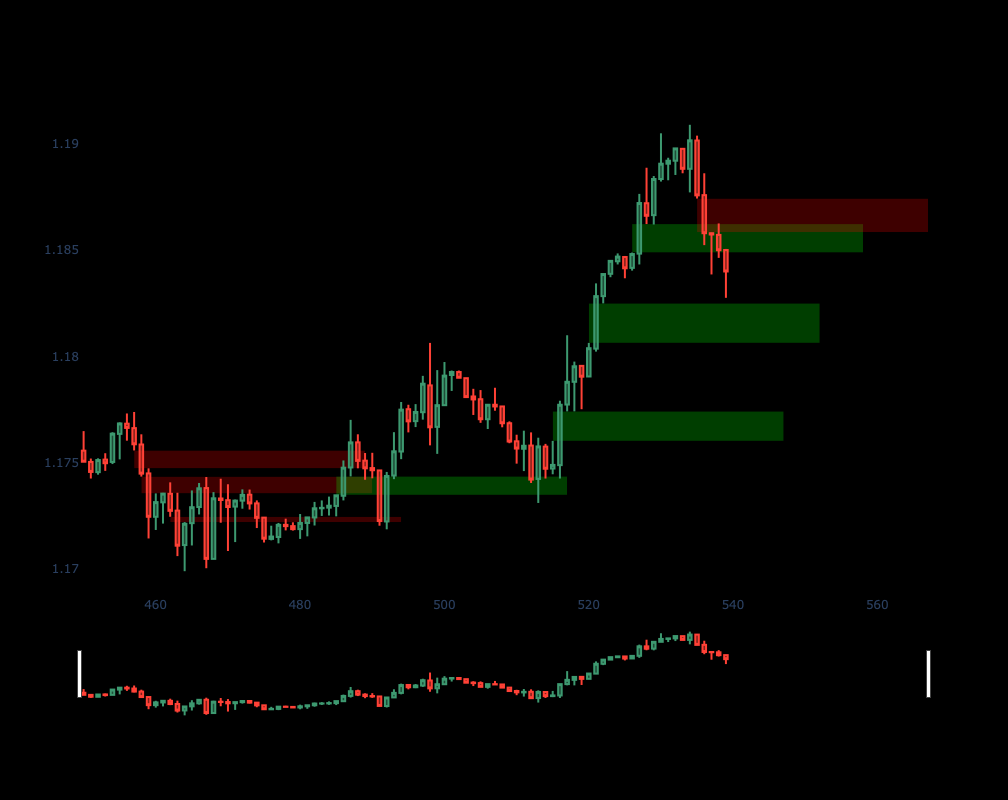

In [30]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
dfpl = df[450:540]
# Create the figure
fig = go.Figure()

# Add candlestick chart
fig.add_trace(go.Candlestick(
    x=dfpl.index,
    open=dfpl["Open"],
    high=dfpl["High"],
    low=dfpl["Low"],
    close=dfpl["Close"],
    name="Candles"
))

# Add FVG zones
for _, row in dfpl.iterrows():
    if isinstance(row["FVG"], tuple):
        fvg_type, start, end, index = row["FVG"]
        color = "rgba(0,255,0,0.3)" if fvg_type == "bullish" else "rgba(255,0,0,0.3)"
        fig.add_shape(
            type="rect",
            x0=index -2,
            x1=index + 30,
            y0=start,
            y1=end,
            fillcolor=color,
            opacity=0.8,
            layer="below",
            line=dict(width=0),
        )

# Show the chart
fig.update_layout(width=1200, height=800,
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False),
                  plot_bgcolor='black',
                  paper_bgcolor='black')
fig.show()